In [1]:
! pip install numpyro corner healpy einops reproject

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 98.9 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=242d6beb702442b8ba06d0bba7735d088b7c5636bfa00c3853fa14533f06f6ec
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [2]:
# run only if LaTeX is needed
! sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript javascript-common
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libharfbuzz-icu0 libidn11
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpdfbox-java
  libptexenc1 libruby2.7 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data preview-latex-style
  rake ruby ruby-minitest ruby-net-telnet ruby-power-assert ruby-test-unit
  ruby-xmlrpc ruby2.7 rubygems-integration t1utils tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-pictures texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fon

In [3]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r'/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/')
%cd /content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks

Mounted at /content/drive
/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks


In [4]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle

import jax
import numpyro.handlers as handlers
from numpyro.infer import Trace_ELBO

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('matplotlibrc')

In [19]:
from models.poissonian_cart import GCEPyModel

In [20]:
output_dir = '../output/posteriors/compare_gcepy'

## 1. fit
### 1.1 single energy

In [23]:
! ls ../data/bulge_templates

bb_front_only_14_Ebin_20x20window_normal.npy
bbp_front_only_14_Ebin_20x20window_normal.npy
BoxyBulge_arxiv1901.03822_Normalized.fits
Bulge_modulated_Coleman_etal_2019_Normalized.fits
Bulge_modulated_Coleman_etal_2019_Normalized.npy
colman_bulge_front_only_14_Ebin_20x20window_normal.npy
x_front_only_14_Ebin_20x20window_normal.npy


In [26]:
m = GCEPyModel()
for i in range(14):
    print(np.mean(m.temps['gce_c19'][i]))

0.31773886
0.36661395
0.40034243
0.4134156
0.4027518
0.38000175
0.33595031
0.27629676
0.21501206
0.15700537
0.10774507
0.1368001
0.022174273
0.0016105113


In [30]:
ebinmodel = GCEPyModel(dif_names=['7p'], gce_names=['c19'])
run_name = '7p_c19'
os.makedirs(f'{output_dir}/{run_name}', exist_ok=True)

In [31]:
for ie in range(14):
    svi_results = ebinmodel.fit_SVI(
        rng_key=jax.random.PRNGKey(123),
        n_steps=20000,
        guide='iaf',
        lr=5e-5,
        num_flows=5,
        hidden_dims=[128, 128],
        num_particles=64,
        ebin=ie,
        error_mode='none',
    )
    trace_elbo = Trace_ELBO(num_particles=1000) 
    elbo_loss = trace_elbo.loss(
        jax.random.PRNGKey(242),
        svi_results.params,
        ebinmodel.model,
        ebinmodel.guide,
        ebin=ie,
        error_mode='none',
    )
    samples = ebinmodel.get_svi_samples(num_samples=50000, expand_samples=True)
    pickle.dump(samples, open(f'{output_dir}/{run_name}/ie{ie}_samples.p', 'wb'))
    pickle.dump((svi_results, elbo_loss), open(f'{output_dir}/{run_name}/ie{ie}_fitinfo.p', 'wb'))

100%|██████████| 20000/20000 [00:34<00:00, 579.98it/s, init loss: 21068972.0000, avg. loss [19001-20000]: 28350.0273]


### 1.2 full

In [ ]:
svi_results = ebinmodel.fit_SVI(
    rng_key=jax.random.PRNGKey(434534),
    num_flows=5, hidden_dims=[128, 128],
    n_steps=20000, lr=5e-5, num_particles=64,
    ebin='all',
    error_mode='none',
)

In [ ]:
svi_results.losses[-1]

In [ ]:
samples = ebinmodel.get_svi_samples(num_samples=50000, expand_samples=True)
pickle.dump((samples, svi_results), open(f'{output_dir}/gcepy_svi_full_errll_par16_3.p', 'wb'))

## 2. Plotting

In [ ]:
from utils.plotting import multi_corner

In [34]:
ebin_edges = np.array([0.275, 0.357, 0.464, 0.603, 0.784, 1.02, 1.32, 1.72,
                       2.24, 2.91, 3.78, 4.91, 10.8, 23.7, 51.9])
ebin_centers = (ebin_edges[1:] + ebin_edges[:-1]) / 2

### 2.1 corner

In [ ]:
ie_tot = 14
samples_dict = {
    str(ie) : pickle.load(open(f'{output_dir}/8t_dm/ie{ie}_samples.p', 'rb'))
    for ie in range(ie_tot)
}
colors_dict = {
    str(ie) : mpl.cm.get_cmap('rainbow')(ie/(ie_tot-1))
    for ie in range(ie_tot)
}
plot_var_names = [
    'S_bub', 'S_gce', 'S_ics', 'S_iso', 'S_pib',
]
multi_corner(
    samples_dict, plot_var_names,
    colors_dict=colors_dict,
)

### 2.2 evidence

In [32]:
run_names = ['7p_dm', '7p_c19', '8t_dm', '8t_c19', '7p_c19nopsf', '8t_c19nopsf']

elbo_dict = {
    run_name : - np.array([
        pickle.load(open(f'{output_dir}/{run_name}/ie{ie}_fitinfo.p', 'rb'))[1]
        for ie in range(14)
    ])
    for run_name in run_names
}

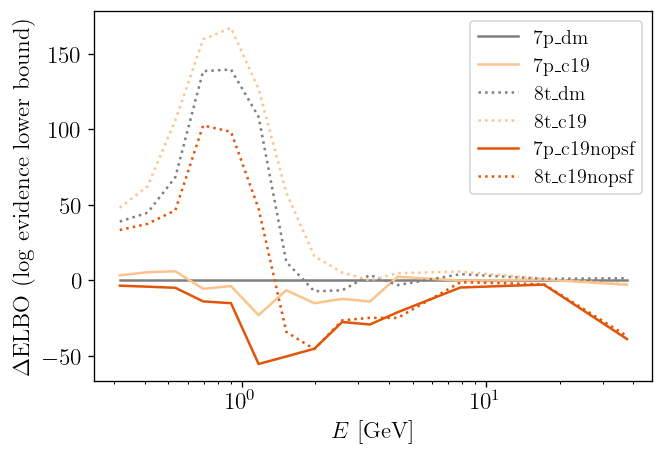

In [35]:
color_dict = {
    'dm' : mpl.colormaps['binary'](0.5),
    'c19' : mpl.colormaps['Oranges'](0.3),
    'c19nopsf' : mpl.colormaps['Oranges'](0.7),
}
linestyle_dict = {
    '7p' : '-',
    '8t' : ':',
}
base = elbo_dict['7p_dm']

fig, ax = plt.subplots()

for i, run_name in enumerate(run_names):
    color = color_dict[run_name.split('_')[1]]
    linestyle = linestyle_dict[run_name.split('_')[0]]
    ax.plot(ebin_centers, elbo_dict[run_name]-base, color=color, label=run_name, linestyle=linestyle)
ax.set(xscale='log')
ax.set(xlabel='$E$ [GeV]', ylabel='$\Delta$ELBO (log evidence lower bound)')
ax.legend(fontsize=12);

In [ ]:
samples_dict = {
    'noerr' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full.p', 'rb'))[0],
    #'errll' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll.p', 'rb'))[0],
    'errll_1' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16_1.p', 'rb'))[0],
    'errll_2' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16_2.p', 'rb'))[0],
    'errll_3' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16_3.p', 'rb'))[0],
}
colors_dict = {
    'noerr' : mpl.colormaps['binary'](0.5),
    'errll' : mpl.colormaps['binary'](0.9),
    'errll_1' : mpl.colormaps['viridis'](0.7),
    'errll_2' : mpl.colormaps['viridis'](0.8),
    'errll_3' : mpl.colormaps['viridis'](0.9),
}
labels_dict = {
    'noerr' : 'No errors',
    'errll' : 'Errors in log likelihood',
    'errll_1' : 'Errors in log likelihood run 1 (num_particle=16)',
    'errll_2' : 'Errors in log likelihood run 2 (num_particle=16)',
    'errll_3' : 'Errors in log likelihood run 3 (num_particle=16)',
}
plot_var_names = [
    'theta_gce_bb', 'theta_gce_dm',
    'S_bub', 'S_gce', 'S_ics', 'S_iso', 'S_pib',
]
multi_corner(
    samples_dict, plot_var_names,
    colors_dict=colors_dict, labels_dict=labels_dict,
    save_fn=f"{output_dir}/plots/gcepy_full.pdf",
)

## Debug

In [ ]:
with handlers.seed(rng_seed=42):
    ll = ebinmodel.model()

In [36]:
m = GCEPyModel()